# Chapter5 案例练习——Python文本挖掘

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 读取数据

In [3]:
dtype = {
    "InvoiceNo": "string",
    "StockCode": "string",
    "Description": "string",
    "Quantity": "int32",
    "UnitPrice": "float32",
    "CustomerID": "string",
    "Country": "string"
}

filename = '../data/Online Retail Preprocessing.xlsx'
sales_success = pd.read_excel(filename, sheet_name='Online Retail Preprocessing', dtype=dtype, engine='calamine')

In [4]:
sales_success.dtypes

InvoiceNo        string[python]
StockCode        string[python]
Description      string[python]
Quantity                  int32
InvoiceDate      datetime64[ns]
UnitPrice               float32
CustomerID       string[python]
Country          string[python]
UnitPrice_RMB           float64
SumPrice                float64
Month                     int64
Date             datetime64[ns]
Dayofweek                 int64
Quarter                   int64
Hour                      int64
dtype: object

In [5]:
sales_success.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,UnitPrice_RMB,SumPrice,Month,Date,Dayofweek,Quarter,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,23.1030,138.6180,12,2010-12-01,2,4,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,30.7134,184.2804,12,2010-12-01,2,4,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,24.9150,199.3200,12,2010-12-01,2,4,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,30.7134,184.2804,12,2010-12-01,2,4,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,30.7134,184.2804,12,2010-12-01,2,4,8


## 数据预处理

### 分组聚合

In [6]:
good_grouped = sales_success.groupby(['StockCode', 'Description'], as_index=False)[['SumPrice','Quantity']].sum()
good_grouped

,StockCode,Description,SumPrice,Quantity
0,10002,INFLATABLE POLITICAL GLOBE,6884.6034,860
1,10080,GROOVY CACTUS INFLATABLE,1078.9554,303
2,10120,DOGGY RUBBER,365.2992,192
3,10123C,HEARTS WRAPPING TAPE,29.4450,5
4,10124A,SPOTS ON RED BOOKCOVER TAPE,60.8832,16
...,...,...,...,...
4156,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1513.4730,10
4157,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1590.3018,7
4158,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,912.3420,3
4159,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1518.0936,4


### 生成热门分类变量

In [7]:
good_grouped['Quantity'].median()

np.float64(323.0)

In [8]:
good_grouped['Quantity'].mean()

np.float64(1339.2021148762317)

In [9]:
threshold = good_grouped['Quantity'].quantile(0.8)
threshold

np.float64(1752.0)

In [10]:
from sklearn.preprocessing import Binarizer

binarizer = Binarizer(threshold=threshold)
good_grouped['Hot'] = binarizer.fit_transform(good_grouped[['Quantity']])

In [11]:
good_grouped.head()

,StockCode,Description,SumPrice,Quantity,Hot
0,10002,INFLATABLE POLITICAL GLOBE,6884.6034,860,0
1,10080,GROOVY CACTUS INFLATABLE,1078.9554,303,0
2,10120,DOGGY RUBBER,365.2992,192,0
3,10123C,HEARTS WRAPPING TAPE,29.4450,5,0
4,10124A,SPOTS ON RED BOOKCOVER TAPE,60.8832,16,0


In [12]:
good_grouped.Hot.value_counts()

Hot
0    3330
1     831
Name: count, dtype: int64

## 文本分类

### 训练集-测试集划分

In [13]:
from sklearn.model_selection import train_test_split
X = good_grouped.Description
y = good_grouped.Hot

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

### 词袋模型

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

default_vect = CountVectorizer().fit(X_train)
X_train_bag = default_vect.transform(X_train)
X_test_bag = default_vect.transform(X_test)
print("X_train:\n{}".format(repr(X_train_bag)))

X_train:
<2912x1846 sparse matrix of type '<class 'numpy.int64'>'
	with 12489 stored elements in Compressed Sparse Row format>


In [15]:
feature_names = default_vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 1846
First 20 features:
['00' '10' '11' '12' '120cm' '125g' '15cm' '16' '16954' '16956' '16957'
 '16960' '16961' '16963' '16965' '16x16cm' '17067' '17068' '17070' '17074']
Features 20010 to 20030:
[]
Every 2000th feature:
['00']


In [16]:
pd.DataFrame(X_train_bag.toarray(), columns=default_vect.get_feature_names_out())

,00,10,11,12,120cm,125g,15cm,16,16954,16956,...,wraps,wreath,wrecking,writing,xmas,yellow,you,your,yuletide,zinc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 可视化

In [17]:
!pip install wordcloud

In [18]:
all_words = ' '.join([' '.join(sentence) for sentence in default_vect.inverse_transform(X_train_bag)])
all_words

'for one retro tea asstd flowers fridge fruit magnets jigsaw mini purdey bow brooch colour diamante red asstd car design pen racing box cottage keepsake rose hanging lantern metal star cover crochet flower food red bling key ring stand enchanted forest ivory placemat house pencil shape sharpener edge folding pointed scissor small bag blue cosmetic embroidery green black diamante diamon drop earrings bell heart holly metal painted with alphabet design wrap bead box jewel pink vintage 36 pencils skulls tube metal neighbourhood sign witch bracelet green sweetheart blue cutlery piece polkadot set clock diner pink wall assorted colour holder light bottle charlie hot lola red water frame mini oval portrait blue floral monster can heat if mug stand the you frangipani necklace purple bitty chain light pink 12 art card folk greeting pack bag charlotte pink polkadot baroque butterfly earrings red antique hook ivory rose single blue check crusoe lampshade glass jar marmalade doormat sunrise welco

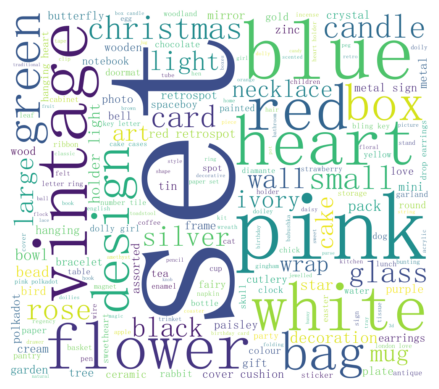

In [19]:
# 生成词云
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator  # 引入词云WordCloud

# WordCloud()设定词云参数，.generate()将str文本生成词云
wordcloud = WordCloud(
    font_path="C:/Windows/Fonts/simfang.ttf", 
    background_color="white",
    width=1000,
    height=880,
).generate(all_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# wordcloud.to_file("cloud1.jpg") # 保存图片

### 分类算法

#### LogisticRegression

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_bag, y_train)
y_pred = lr.predict(X_test_bag)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8366693354683747

In [22]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = lr.predict(X_test_bag)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, lr.predict_proba(X_test_bag)[:, 1]):.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       997
           1       0.68      0.36      0.47       252

    accuracy                           0.84      1249
   macro avg       0.77      0.66      0.69      1249
weighted avg       0.82      0.84      0.82      1249

AUC-ROC: 0.84


#### 朴素贝叶斯

In [23]:
from sklearn.naive_bayes import MultinomialNB

# 训练朴素贝叶斯分类器
nb = MultinomialNB()
nb.fit(X_train_bag, y_train)

# 预测
y_pred = nb.predict(X_test_bag)

# 计算准确率
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# 详细分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, nb.predict_proba(X_test_bag)[:, 1]):.2f}")

Accuracy: 0.825

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       997
           1       0.59      0.42      0.49       252

    accuracy                           0.82      1249
   macro avg       0.73      0.68      0.69      1249
weighted avg       0.81      0.82      0.81      1249

AUC-ROC: 0.81


#### SVM

In [24]:
from sklearn.svm import SVC

# 训练SVM分类器
svm = SVC(kernel='rbf', probability=True, random_state=0)
svm.fit(X_train_bag, y_train)

# 预测
y_pred = svm.predict(X_test_bag)

# 计算准确率
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# 详细分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, svm.predict_proba(X_test_bag)[:, 1]):.2f}")

Accuracy: 0.835

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       997
           1       0.76      0.27      0.39       252

    accuracy                           0.84      1249
   macro avg       0.80      0.62      0.65      1249
weighted avg       0.82      0.84      0.80      1249

AUC-ROC: 0.83


#### 决策树

In [25]:
from sklearn.tree import DecisionTreeClassifier

# 训练决策树分类器
dt = DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_split=5)
dt.fit(X_train_bag, y_train)

# 预测
y_pred = dt.predict(X_test_bag)

# 计算准确率
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# 详细分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, dt.predict_proba(X_test_bag)[:, 1]):.2f}")

Accuracy: 0.802

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       997
           1       0.52      0.21      0.30       252

    accuracy                           0.80      1249
   macro avg       0.68      0.58      0.59      1249
weighted avg       0.77      0.80      0.77      1249

AUC-ROC: 0.57


#### 随机森林

In [26]:
from sklearn.ensemble import RandomForestClassifier

# 训练随机森林分类器
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=10)
rf.fit(X_train_bag, y_train)

# 预测
y_pred = rf.predict(X_test_bag)

# 计算准确率
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# 详细分类报告
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, rf.predict_proba(X_test_bag)[:, 1]):.2f}")

Accuracy: 0.799

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       997
           1       1.00      0.00      0.01       252

    accuracy                           0.80      1249
   macro avg       0.90      0.50      0.45      1249
weighted avg       0.84      0.80      0.71      1249

AUC-ROC: 0.79


### 特征优化

In [27]:
from sklearn.model_selection import train_test_split
X = good_grouped.Description
y = good_grouped.Hot

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

#### 文本清洗和选择

In [28]:
import re
from sklearn.feature_extraction.text import CountVectorizer

def custom_tokenizer(document):
    document = re.sub(r'[^a-zA-Z\s]', '', document)
    return document.split()

# 利用自定义分词器来定义一个计数向量器
count_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=2, max_df=0.95, stop_words="english", ngram_range=(1, 2), token_pattern=None).fit(X_train)

In [29]:
count_vect = CountVectorizer(min_df=2, max_df=0.5, stop_words="english", ngram_range=(1, 2)).fit(X_train)

In [30]:
X_train_bag = count_vect.transform(X_train)
X_test_bag = count_vect.transform(X_test)

In [31]:
pd.DataFrame(X_train_bag.toarray(), columns=count_vect.get_feature_names_out())

,00,10,10 card,10 cards,12,12 blue,12 colour,12 coloured,12 lights,12 pencils,...,xmas,yellow,yellow flowers,yellow pink,zinc,zinc glass,zinc heart,zinc light,zinc star,zinc wire
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
lr = LogisticRegression()
lr.fit(X_train_bag, y_train)
y_pred = lr.predict(X_test_bag)

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8390712570056045

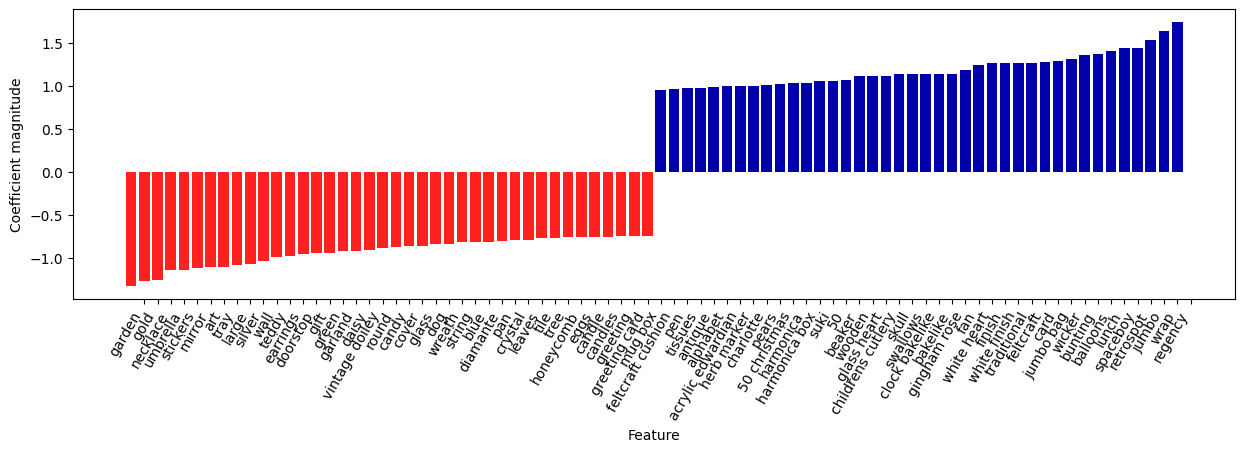

In [34]:
import mglearn
feature_names = np.array(count_vect.get_feature_names_out())
coef = lr.coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
plt.show()

#### TfidfVectorizer

In [35]:
from sklearn.model_selection import train_test_split
X = good_grouped.Description
y = good_grouped.Hot

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    min_df=2,  # 忽略低频词
    max_df=0.95,  # 忽略高频常见词
    ngram_range=(1, 2)  # 捕捉词组
).fit(X_train)

In [37]:
X_train_bag = tfidf_vect.transform(X_train)
X_test_bag = tfidf_vect.transform(X_test)

In [38]:
lr = LogisticRegression()
lr.fit(X_train_bag, y_train)
y_pred = lr.predict(X_test_bag)

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8294635708566853

## 文本聚类

### 数据预处理

In [40]:
X = good_grouped.Description

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

default_vect = CountVectorizer().fit(X)
bag_of_words = default_vect.transform(X)

### KMeans聚类

In [42]:
from sklearn.cluster import KMeans

X = bag_of_words.toarray().T
clf = KMeans(n_clusters=5)
s = clf.fit(X)
cluster_labels = clf.labels_
cluster_labels

array([4, 4, 4, ..., 4, 4, 4], shape=(2137,), dtype=int32)

In [43]:
words = pd.DataFrame() # to DataFrame
words['words'] = default_vect.get_feature_names_out()
words['labels'] = cluster_labels
words

,words,labels
0,00,4
1,10,4
2,100,4
3,11,4
4,12,4
...,...,...
2132,yellow,4
2133,you,4
2134,your,4
2135,yuletide,4


In [44]:
words.groupby('labels')['words'].unique()

labels
0                                     [classic, sugar]
1    [crystal, earrings, heart, holder, light, neck...
2                                              [glass]
3                                           [spaceboy]
4    [00, 10, 100, 11, 12, 120cm, 125g, 15, 15c, 15...
Name: words, dtype: object

### LDA主题建模

In [45]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10  # 根据业务需求调整
lda = LatentDirichletAllocation(n_components=n_topics,
                                learning_method="batch",
                                max_iter=25,
                                random_state=0)

In [46]:
document_topics = lda.fit_transform(bag_of_words)

In [47]:
lda.components_.shape

(10, 2137)

In [48]:
def print_topics(model, vectorizer, n_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" | ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))

print("----- 主题关键词分布 -----")
print_topics(lda, default_vect)

----- 主题关键词分布 -----
Topic #0:
ring | key | pink | letter | bling | reel | ribbon | bracelet | sweetheart | white
Topic #1:
cake | of | mug | design | set | tea | fairy | stand | pink | plate
Topic #2:
red | glass | necklace | retrospot | bracelet | green | silver | charm | heart | bead
Topic #3:
12 | clock | bottle | girl | dolly | pack | party | hot | wall | water
Topic #4:
bag | metal | blue | pink | vintage | sign | wrap | paper | paisley | easter
Topic #5:
earrings | pink | vintage | frame | black | mirror | blue | photo | felt | drop
Topic #6:
set | of | box | garden | 10 | cutlery | lights | cards | paper | vintage
Topic #7:
christmas | decoration | heart | hanging | with | love | tree | pink | bird | cushion
Topic #8:
holder | light | heart | wall | art | ivory | small | large | hanging | candle
Topic #9:
rose | card | assorted | home | in | hook | vintage | doormat | box | candle


In [49]:
topic_names = ["Topic_" + str(i) for i in range(n_topics)]
doc_topic_df = pd.DataFrame(document_topics, columns=topic_names)
doc_topic_df['Dominant_Topic'] = doc_topic_df.idxmax(axis=1)
results = pd.concat([good_grouped['Description'], doc_topic_df], axis=1)
results

,Description,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Dominant_Topic
0,INFLATABLE POLITICAL GLOBE,0.025000,0.025003,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.774997,Topic_9
1,GROOVY CACTUS INFLATABLE,0.025000,0.774990,0.025000,0.025000,0.025000,0.025000,0.025007,0.025000,0.025000,0.025003,Topic_1
2,DOGGY RUBBER,0.033333,0.033354,0.033333,0.033333,0.699979,0.033333,0.033333,0.033333,0.033333,0.033333,Topic_4
3,HEARTS WRAPPING TAPE,0.025000,0.025000,0.025000,0.025001,0.774973,0.025003,0.025005,0.025018,0.025000,0.025001,Topic_4
4,SPOTS ON RED BOOKCOVER TAPE,0.016667,0.016667,0.016677,0.576341,0.016674,0.016672,0.016667,0.290298,0.016669,0.016668,Topic_3
...,...,...,...,...,...,...,...,...,...,...,...,...
4156,Dotcomgiftshop Gift Voucher £20.00,0.849979,0.016667,0.016667,0.016667,0.016669,0.016667,0.016667,0.016668,0.016667,0.016682,Topic_0
4157,Dotcomgiftshop Gift Voucher £30.00,0.849994,0.016667,0.016667,0.016667,0.016670,0.016667,0.016667,0.016667,0.016667,0.016668,Topic_0
4158,Dotcomgiftshop Gift Voucher £40.00,0.651486,0.016667,0.016667,0.016668,0.016670,0.016667,0.016667,0.016667,0.016667,0.215175,Topic_0
4159,Dotcomgiftshop Gift Voucher £50.00,0.849977,0.016667,0.016668,0.016667,0.016669,0.016667,0.016670,0.016679,0.016667,0.016668,Topic_0


## 课堂练习